**Тематическое моделирование на примере корпуса русских стихотворений**

Источник датасета: https://www.kaggle.com/datasets/greencools/russianpoetry

In [136]:
import numpy as np
import pandas as pd

df = pd.read_csv("data\\russianPoetryWithTheme.csv")
df.head()

random_state = 1337

Предобработка и лемматизация корпуса

In [137]:
# !pip install pymorphy2

import pymorphy2
import re
import nltk
nltk.download('stopwords')

def pre_process(string, morph):
    string = string.lower()
    string = re.sub(r'[^\w\s]','',string) # Удаление знаков препинания

    tokens = nltk.word_tokenize(string)
    stop_words = nltk.corpus.stopwords.words('russian')
    filtered_tokens = [w for w in tokens if not w in stop_words and len(w) > 2]

    lemmatized_tokens = [morph.parse(word)[0].normal_form for word in filtered_tokens] # Лемматизация (slow af)

    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\St0negor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
morph = pymorphy2.MorphAnalyzer()
print(pre_process('Пример выполнения функции предобработки к тексту, написанному с использованием знаков препинания, стоп слов и ПРОПИСНЫХ БУКВ\r\n',morph))

пример выполнение функция предобработка текст написать использование знак препинание стоп слово прописной буква


In [139]:
%%time
import swifter

morph = pymorphy2.MorphAnalyzer()
text = df['text']
text = text.swifter.apply(lambda x: pre_process(x,morph))

Pandas Apply:   0%|          | 0/16694 [00:00<?, ?it/s]

Wall time: 2min 56s


In [140]:
print(text[1337])

хоровод рифма сладко дышаться вечерний воздух колыхаться немой нежный роза дух высь оранжевый даль лазоревый забыть гора прийти ранний чистый озеро куст акация стать грёза перо писать варьяции петь элегия романс пылкий ссылка нега медлить румянец золото иль страсть исполоть слово бред луна луч палевый пробраться перепел листва эмалевый роса перепить тоска сердечный отдаться муза я иллюзия миф вечный нервно молния сверкать змея пойти аллея поехать чёлн волна озеро топить бессилие жизнь роза сера крылия орёл синь поплыть чудесный мечта уныние проклясть тесный лживый роза дух мой иллюзия душа контузия больной воздух высь стать сумрачный даль фиолетовый душа дума мрачный тихий пульс считать маятник грудь конвульсия счастие памятник


Обработка текста в формат, воспринимаемый BigARTM

In [141]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.01, lowercase=False) # min_df = 0.01 уберет слова, встречающиеся реже 1 процента во всех стихотворениях, что уменьшит размерность вектора,
vectors = vectorizer.fit_transform(text)                                                # а это значит меньше вычислений для моего слабого компуктера
vectors = vectors.transpose() # - Формат BOW, воспринимаемый BigARTM

In [142]:
print(vectors.shape)

(1238, 16694)


In [143]:
feature_names = vectorizer.get_feature_names_out()

vocabulary = {i: feature_name for i, feature_name in enumerate(feature_names)}

print(vocabulary)

{0: 'ангел', 1: 'башня', 2: 'бег', 3: 'беда', 4: 'бедный', 5: 'бежать', 6: 'бездна', 7: 'безмолвный', 8: 'безумный', 9: 'белые', 10: 'белый', 11: 'берег', 12: 'берёза', 13: 'бессмертный', 14: 'битва', 15: 'бить', 16: 'биться', 17: 'благо', 18: 'блаженный', 19: 'блаженство', 20: 'бледный', 21: 'блеск', 22: 'блеснуть', 23: 'блестеть', 24: 'блестящий', 25: 'близкий', 26: 'близко', 27: 'блистать', 28: 'бог', 29: 'богатый', 30: 'боевой', 31: 'боец', 32: 'божественный', 33: 'божий', 34: 'бой', 35: 'бок', 36: 'болото', 37: 'боль', 38: 'больно', 39: 'больной', 40: 'больший', 41: 'большой', 42: 'борьба', 43: 'бояться', 44: 'брат', 45: 'брать', 46: 'бред', 47: 'бровь', 48: 'бродить', 49: 'бросать', 50: 'бросить', 51: 'буйный', 52: 'бурный', 53: 'буря', 54: 'бывало', 55: 'бывать', 56: 'былой', 57: 'быстро', 58: 'быстрый', 59: 'бытие', 60: 'быть', 61: 'вал', 62: 'ваш', 63: 'вдали', 64: 'вдаль', 65: 'вдвоём', 66: 'вдоль', 67: 'вдохновение', 68: 'ведать', 69: 'везде', 70: 'век', 71: 'великий', 72: '

ARTM модель

In [144]:
import artm
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',n_wd=vectors,vocabulary=vocabulary)

In [145]:
dictionary = batch_vectorizer.dictionary
num_topics = 7
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)],seed=random_state)

In [146]:
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20))

In [147]:
model_artm.num_document_passes = 1
model_artm.initialize(dictionary)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

PerplexityScore score: 803.197


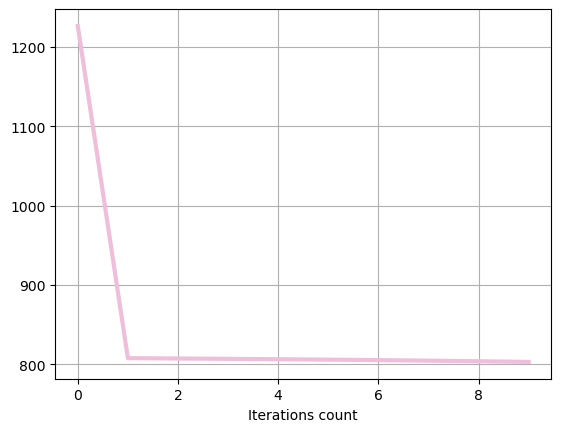

In [148]:
import matplotlib.pyplot as plt

def print_measures(model, names):
    for name in names:
        print(f'{name} score: {model.score_tracker[name].last_value:.3f}')
        plt.plot(range(model.num_phi_updates),model.score_tracker[name].value, c=np.random.rand(3,), linewidth=3)
    plt.xlabel('Iterations count')
    plt.grid(True)
    plt.show()

print_measures(model_artm,['PerplexityScore'])

Выведем ключевые слова из каждой темы, чтобы сделать выводы о результате работы модели.

In [149]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['сказать', 'ты', 'стать', 'свой', 'наш', 'душа', 'мой', 'рука', 'звезда', 'видеть', 'небо', 'ветер', 'дорога', 'твой', 'жизнь', 'любовь', 'огонь', 'солнце', 'песня', 'слышать']
topic_1: 
['знать', 'это', 'день', 'душа', 'жизнь', 'вода', 'слово', 'год', 'жить', 'всё', 'пусть', 'тишина', 'любить', 'волна', 'пора', 'этот', 'весь', 'ваш', 'ты', 'глядеть']
topic_2: 
['мой', 'твой', 'свой', 'ночь', 'глаз', 'день', 'чёрный', 'друг', 'рука', 'душа', 'весь', 'наш', 'год', 'человек', 'стать', 'казаться', 'тень', 'видеть', 'словно', 'сила']
topic_3: 
['твой', 'сердце', 'свой', 'ты', 'ночь', 'любить', 'свет', 'земля', 'путь', 'рука', 'мы', 'небо', 'вода', 'это', 'идти', 'белый', 'жизнь', 'ветер', 'один', 'жить']
topic_4: 
['твой', 'наш', 'день', 'ты', 'дом', 'мы', 'любовь', 'друг', 'свет', 'один', 'пусть', 'сон', 'глаз', 'хотеть', 'мир', 'говорить', 'слово', 'сказать', 'свой', 'жить']
topic_5: 
['сердце', 'земля', 'любовь', 'весь', 'жизнь', 'мы', 'мой', 'один', 'год', 'сон', 'мочь', 'бо

Многие темы сложно интерпретируемы человеком, помимо этого они пересекаются в своих мотивах.
Также важно заметить, что местоимения попали в каждую из тем, поэтому стоит предположить, что они не приносят полезной информации модели, возможно следует исключить их из словаря.

Попробуем оптимизировать гиперпараметры модели, чтобы улучшить качество её работы.

Значение Perplexity, расчитанное на тренировочных данных, не лучший способ оценки результата работы тематического моделирования.
Тогда стоит разделить данные для тренировки и валидации модели, чтобы посчитать held-out-perplexity.

Еще одна важная метрика, которая поможет нам оптимизировать модель это topic kernel purity and contrast.
Эта метрика может помочь нам повысить интерпретируемость тем.
"This score was created as one more way to control the interpretability of the topics. <...> Average purity and contrast can be used as a measure of topics interpretability and difference." - [Документация BigARTM](https://bigartm.readthedocs.io/en/stable/tutorials/scores_descr.html#topic-kernel-scores)

In [150]:
vectors_shuffled = vectors.copy().transpose() # сначала необходимо транспонировать матрицу, чтобы переставить документы, а не слова.

indices = np.arange(vectors_shuffled.shape[0])
np.random.seed(random_state)                            # случайным образом перемешать документы
np.random.shuffle(indices)
vectors_shuffled = vectors_shuffled[list(indices)]

vectors_shuffled = vectors_shuffled.transpose()

length = vectors.shape[0]

split = 0.1 # Пропорция документов для валидации

vectors_train = vectors_shuffled[round(length*split):]
vectors_val = vectors_shuffled[:round(length*split)]

Определим ту же модель с новыми метриками

In [151]:
batch_vectorizer_train = artm.BatchVectorizer(data_format='bow_n_wd',n_wd=vectors_train,vocabulary=vocabulary)

dictionary = batch_vectorizer_train.dictionary

num_topics = 7
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,seed=random_state)

model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20))

model_artm.scores.add(artm.TopicKernelScore(name='kernel')) # Topic Kernel Score
model_artm.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

model_artm.num_document_passes = 1

model_artm.initialize(dictionary)

model_artm.fit_offline(batch_vectorizer=batch_vectorizer_train, num_collection_passes=10)

perplexity = model_artm.get_score('perplexity')

In [152]:
batch_vectorizer_val = artm.BatchVectorizer(data_format='bow_n_wd',n_wd=vectors_val,vocabulary=vocabulary)
model_artm.transform(batch_vectorizer_val)
perplexity_val = model_artm.get_score('perplexity')

In [153]:
print("perplexity score = {}".format(perplexity.value))
print("held-out-perplexity score = {}".format(perplexity_val.value))
print("kernel purity score = {}".format(np.average(model_artm.get_score('kernel').kernel_purity)))
print("kernel contrast score = {}".format(np.average(model_artm.get_score('kernel').kernel_contrast)))

perplexity score = 715.1897583007812
held-out-perplexity score = 1318.489501953125
kernel purity score = 0.859906119959695
kernel contrast score = 0.20797415290560042


Как и ожидалось, значение held-out-perplexity выше обычного perplexity.

Низкий kernel contrast score показывает, что темы пересекаются между собой.

Используем метрики kernel purity and contrast scores и held-out-perplexity, чтобы подобрать гиперпараметры модели.

Определить значения гиперпараметров нам поможет байесовская оптимизация, имплементацию которой возьмем из библиотеки hyperopt.

In [154]:
def define_model(num_topics, num_collection_passes=15, num_document_passes=1, phi_reg=-1, theta_reg=-0.5, vectors_train=vectors_train, vectors_val=vectors_val):
    batch_vectorizer_train = artm.BatchVectorizer(data_format='bow_n_wd',n_wd=vectors_train,vocabulary=vocabulary)
    dictionary = batch_vectorizer_train.dictionary

    topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

    model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,seed=random_state)

    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))

    model_artm.regularizers['sparse_phi_regularizer'].tau = phi_reg
    model_artm.regularizers['sparse_theta_regularizer'].tau = theta_reg

    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20))
    model_artm.scores.add(artm.TopicKernelScore(name='kernel')) # Topic Kernel Score
    model_artm.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

    model_artm.num_document_passes = int(num_document_passes)

    model_artm.initialize(dictionary)

    model_artm.fit_offline(batch_vectorizer=batch_vectorizer_train, num_collection_passes=int(num_collection_passes))

    if(vectors_val!=None):
        batch_vectorizer_val = artm.BatchVectorizer(data_format='bow_n_wd',n_wd=vectors_val,vocabulary=vocabulary)
        model_artm.transform(batch_vectorizer_val)
    return model_artm

In [170]:
from hyperopt import fmin, hp, tpe, STATUS_OK
import warnings
warnings.filterwarnings('ignore') # BigARTM causes a lot of warnings :(
def objective(params):
    model_artm = define_model(**params)
    kernel_purity = np.average(model_artm.get_score('kernel').kernel_purity)
    kernel_contrast = np.average(model_artm.get_score('kernel').kernel_contrast)
    perplexity = model_artm.get_score('perplexity')
    score =  -(kernel_contrast+kernel_purity*2)*200 + perplexity.value #arbitrarly chosen function aggregating all the metrics
    return {'loss': score,'params':params,'status':STATUS_OK}

search_space = {
    'num_topics': hp.randint('num_topics',5,10),
    'num_collection_passes': hp.quniform('num_collection_passes',5,30,1),
    'num_document_passes': hp.quniform('num_document_passes',1,15,1),
    'phi_reg': hp.uniform('phi_reg',-2,2),
    'theta_reg': hp.uniform('theta_reg',-2,2),
}

In [174]:
%%time

algorithm=tpe.suggest

best_params = fmin(
    fn=objective,
    space=search_space,
    algo=algorithm,
    max_evals=50)

100%|██████████| 50/50 [12:06<00:00, 14.53s/trial, best loss: -363.8589432835579] 
Wall time: 12min 6s


In [178]:
print(best_params)
model_artm = define_model(**best_params, vectors_train=vectors)

{'num_collection_passes': 17.0, 'num_document_passes': 10.0, 'num_topics': 7, 'phi_reg': -1.8863638742142217, 'theta_reg': -1.8929255815215829}


In [179]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['сказать', 'идти', 'говорить', 'друг', 'рука', 'дом', 'ты', 'свой', 'мы', 'наш', 'стать', 'знать', 'сидеть', 'мой', 'один', 'дорога', 'быть', 'конь', 'глаз', 'весь']
topic_1: 
['это', 'год', 'знать', 'человек', 'жить', 'слово', 'жизнь', 'свой', 'который', 'такой', 'день', 'наш', 'мы', 'время', 'каждый', 'один', 'тот', 'стать', 'весь', 'пусть']
topic_2: 
['ветер', 'снег', 'день', 'земля', 'ночь', 'окно', 'небо', 'глаз', 'идти', 'солнце', 'рука', 'чёрный', 'лес', 'белый', 'мой', 'весна', 'весь', 'вода', 'трава', 'сердце']
topic_3: 
['небо', 'волна', 'море', 'твой', 'душа', 'ночь', 'свой', 'звезда', 'земля', 'сон', 'гора', 'тень', 'мир', 'день', 'вода', 'луч', 'солнце', 'взор', 'око', 'берег']
topic_4: 
['наш', 'свой', 'твой', 'мы', 'слава', 'друг', 'народ', 'день', 'ты', 'враг', 'поэт', 'сей', 'царь', 'бой', 'песня', 'весь', 'русский', 'страна', 'стих', 'год']
topic_5: 
['бог', 'человек', 'свой', 'мир', 'жизнь', 'весь', 'смерть', 'земля', 'душа', 'дать', 'сила', 'мы', 'дух', '

Темы оптимизированной модели определенно выглядят чище.
Темы 0-1 сложно определить, однако остальные темы выглядят довольно явно:
Тема 2-3: Природа, где тема 2 больше о русской зиме или весне.
Тема 4: Поэзия.
Тема 5: Народ, война и родина.
Тема 6: Любовь.

Окрасим визуализацию из прошлого задания цветами предсказаний, чтобы понять, отражает ли она тематическую структуру стихотворений.

In [180]:
batch_vectorizer_val = artm.BatchVectorizer(data_format='bow_n_wd',n_wd=vectors,vocabulary=vocabulary)
predicted_topics = model_artm.transform(batch_vectorizer_val).transpose()
predicted_topics = predicted_topics.sort_index()

In [181]:
topics_hard_classified = []
for row in predicted_topics.iterrows():
    topics_hard_classified.append(pd.Series(row)[1].argmax())

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.01, lowercase=False)
tfidf = vectorizer.fit_transform(text)

In [183]:
import umap

In [184]:
%%time
reducer = umap.UMAP(n_components=3, n_neighbors=10, min_dist=0.01, random_state=random_state)
UMAP_3D_embedding = reducer.fit_transform(tfidf)
UMAP_3D_embedding  = np.swapaxes(UMAP_3D_embedding,0,1)

Wall time: 13.7 s


In [185]:
import plotly
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

plotly.offline.init_notebook_mode()
trace = go.Scatter3d(
    x=UMAP_3D_embedding[0],
    y=UMAP_3D_embedding[1],
    z=UMAP_3D_embedding[2],
    mode='markers',
    marker=dict(
        size = 1,
        opacity = 0.5,
        color = topics_hard_classified,
        colorscale=px.colors.sequential.Rainbow
    )
)
scale = px.colors.sequential.Rainbow
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    template=pio.templates["plotly_dark"]
)
data = [trace]
plot_figure = go.Figure(data=data, layout=layout)

plot_figure.write_html("data/UMAP3D_colored.html") # !!! Файл с графиком прикрепил к домашнему заданию, т.к. colab не поддерживает plotly виджеты.
plot_figure.show()

!!! Файл с графиком прикрепил к домашнему заданию, т.к. colab не поддерживает plotly виджеты.

На графике можно явно наблюдать некую структуру в распределении цветов, значит можно сделать вывод, что UMAP неплохо запечатлел взаимосвязи между документами в пространстве высокой размерности.

С какими ещё параметрами можно было бы поэкспериментировать:
1) min_df в CountVectorizer, изменить размер словаря
2) n-grams range, добавить сочетания слов в словарь